Shape: (920, 16)
Columns: ['id', 'age', 'sex', 'dataset', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalch', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'num']
   id  age     sex    dataset               cp  trestbps   chol    fbs  \
0   1   63    Male  Cleveland   typical angina     145.0  233.0   True   
1   2   67    Male  Cleveland     asymptomatic     160.0  286.0  False   
2   3   67    Male  Cleveland     asymptomatic     120.0  229.0  False   
3   4   37    Male  Cleveland      non-anginal     130.0  250.0  False   
4   5   41  Female  Cleveland  atypical angina     130.0  204.0  False   

          restecg  thalch  exang  oldpeak        slope   ca  \
0  lv hypertrophy   150.0  False      2.3  downsloping  0.0   
1  lv hypertrophy   108.0   True      1.5         flat  3.0   
2  lv hypertrophy   129.0   True      2.6         flat  2.0   
3          normal   187.0  False      3.5  downsloping  0.0   
4  lv hypertrophy   172.0  False      1.4    upsloping  0.0   

              

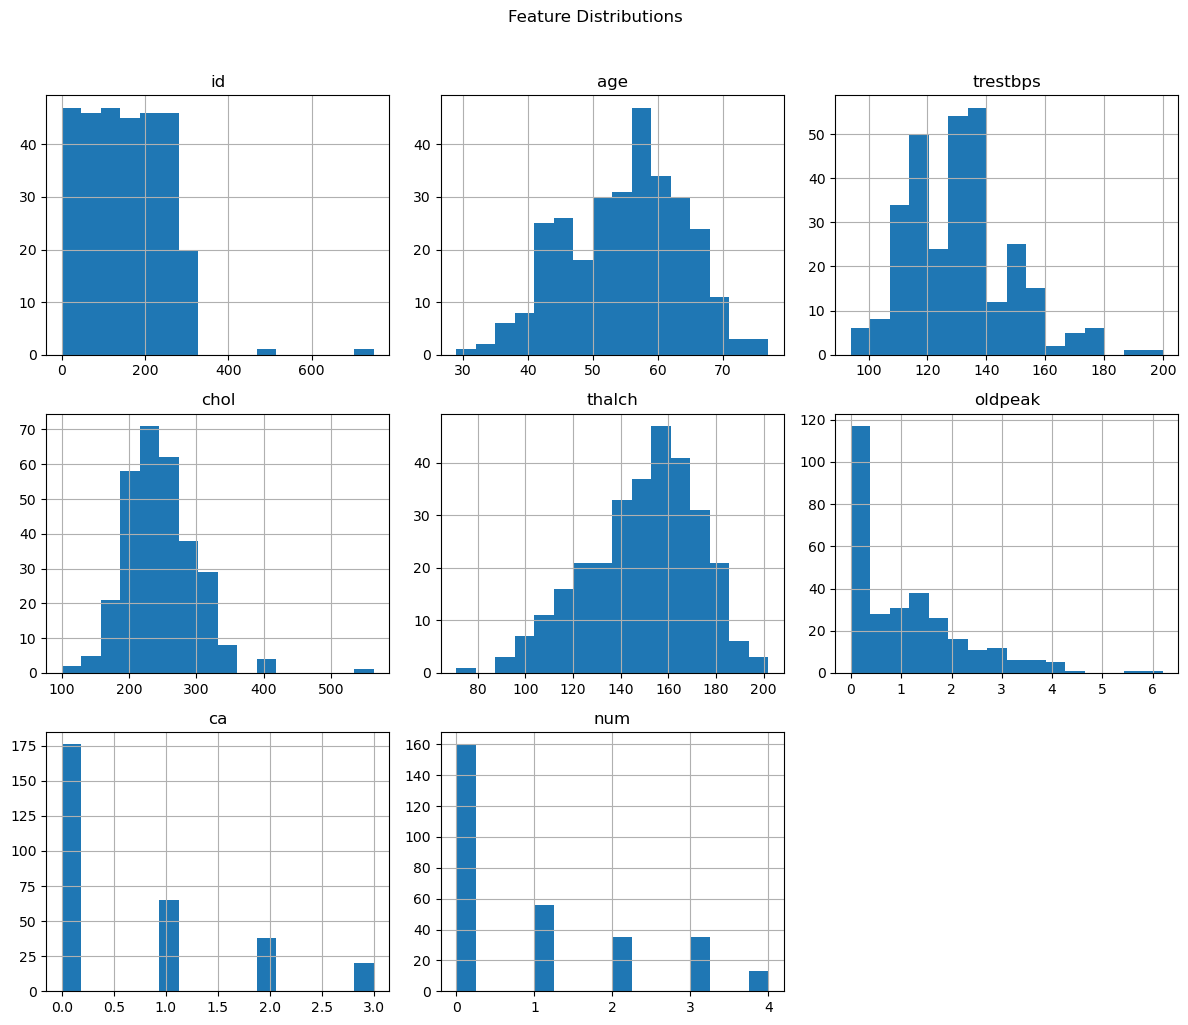

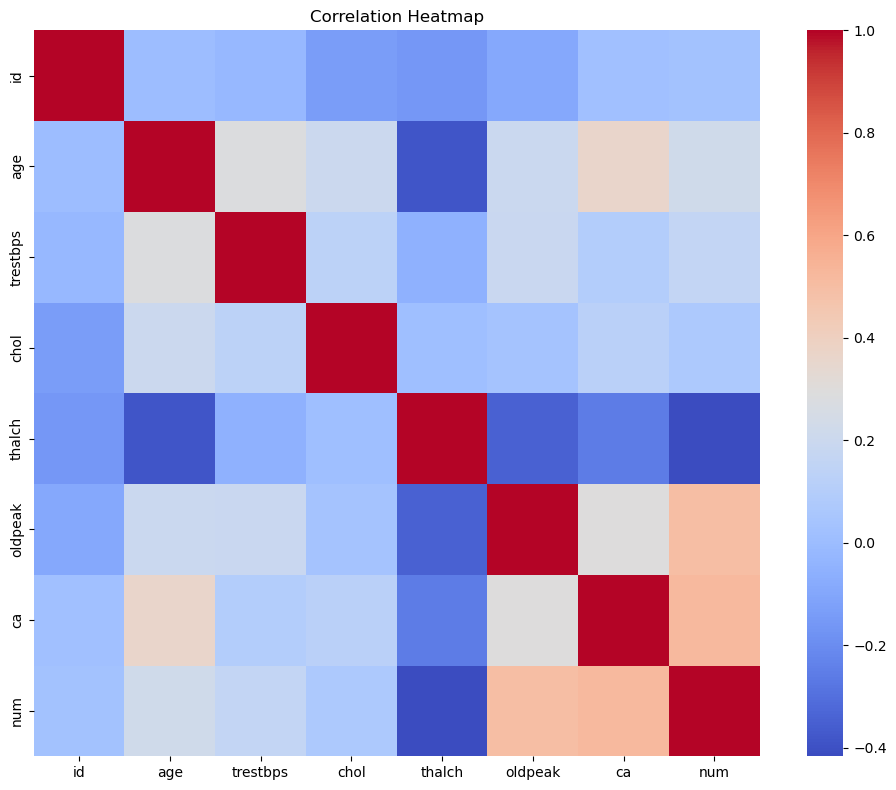

KeyError: "['target'] not found in axis"

In [4]:
# Task 3: Heart Disease Prediction (UCI Heart Dataset)
# ----------------------------------------------------
# Requirements:
# pip install pandas numpy scikit-learn matplotlib seaborn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    roc_curve,
    confusion_matrix,
    ConfusionMatrixDisplay,
)
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline

# -----------------------------
# 1) Load data
# -----------------------------
# Put your CSV path here (Kaggle UCI Heart Disease). Common filenames:
# - heart.csv (Kaggle version with 'target' column: 0 = no disease, 1 = disease)
csv_path = "heart_disease_uci.csv"
df = pd.read_csv(csv_path)

print("Shape:", df.shape)
print("Columns:", df.columns.tolist())
print(df.head())

# -----------------------------
# 2) Basic cleaning
# -----------------------------
# If there are known placeholders for missing values, handle them here.
# The standard Kaggle heart.csv has no missing values, but we’ll be safe:

df.replace([np.inf, -np.inf], np.nan, inplace=True)
missing_before = df.isna().sum()
df = df.dropna()  # simple approach; alternatively use imputation
missing_after = df.isna().sum()
print("\nMissing values before:\n", missing_before)
print("\nMissing values after dropna:\n", missing_after)

# -----------------------------
# 3) EDA (quick view)
# -----------------------------
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

# Histograms
df[numeric_cols].hist(bins=16, figsize=(12, 10))
plt.suptitle("Feature Distributions", y=1.02)
plt.tight_layout()
plt.show()

# Correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df[numeric_cols].corr(), annot=False, cmap="coolwarm", square=True)
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.show()

# -----------------------------
# 4) Train/test split
# -----------------------------
# By convention, Kaggle heart.csv uses 'target' as the label: 1=disease, 0=no disease
target_col = "target"
X = df.drop(columns=[target_col])
y = df[target_col]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# -----------------------------
# 5) Choose a model
#    - Option A: Logistic Regression (with scaling)
#    - Option B: Decision Tree (no scaling needed)
# Toggle by setting MODEL = "logreg" or "tree"
# -----------------------------
MODEL = "logreg"  # "logreg" or "tree"

if MODEL == "logreg":
    model = Pipeline(
        steps=[
            ("scaler", StandardScaler()),
            ("clf", LogisticRegression(max_iter=200, solver="lbfgs")),
        ]
    )
else:
    model = DecisionTreeClassifier(
        max_depth=4, random_state=42
    )

# -----------------------------
# 6) Train
# -----------------------------
model.fit(X_train, y_train)

# -----------------------------
# 7) Evaluate
# -----------------------------
y_proba = (
    model.predict_proba(X_test)[:, 1]
    if hasattr(model, "predict_proba")
    else None
)
y_pred = model.predict(X_test)

acc = accuracy_score(y_test, y_pred)
print(f"\nAccuracy: {acc:.3f}")

if y_proba is not None:
    auc = roc_auc_score(y_test, y_proba)
    print(f"ROC-AUC: {auc:.3f}")

# Confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(values_format="d")
plt.title("Confusion Matrix (0=no disease, 1=disease)")
plt.tight_layout()
plt.show()

# ROC curve
print(f"Accuracy: {acc:.3f}")

if y_proba is not None:  # for models with predict_proba
    auc = roc_auc_score(y_test, y_proba)
    print(f"ROC-AUC: {auc:.3f}")

    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, label=f"ROC (AUC = {auc:.3f})")
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.show()

# -----------------------------
# 8) Feature importance
# -----------------------------
def show_feature_importance(model, X_train, name: str):
    plt.figure(figsize=(8, 6))
    if name == "logreg":
        # Extract coefficients from the LogisticRegression inside the pipeline
        lr = model.named_steps["clf"]
        scaler = model.named_steps["scaler"]
        # Coefficients correspond to scaled features; show as a bar chart
        coefs = lr.coef_[0]
        importance = pd.Series(coefs, index=X_train.columns).sort_values()
        importance.plot(kind="barh")
        plt.title("Feature Importance (Logistic Regression Coefficients)")
        plt.xlabel("Coefficient (scaled)")
    else:
        # Decision tree feature importances
        importances = model.feature_importances_
        importance = pd.Series(importances, index=X_train.columns).sort_values()
        importance.plot(kind="barh")
        plt.title("Feature Importance (Decision Tree)")
        plt.xlabel("Gini Importance")
    plt.tight_layout()
    plt.show()

if MODEL == "logreg":
    show_feature_importance(model, X_train, "logreg")
else:
    show_feature_importance(model, X_train, "tree")

# -----------------------------
# Notes:
# - This script is for educational use only and not for medical diagnosis.
# - Consider cross-validation, hyperparameter tuning (GridSearchCV/RandomizedSearchCV),
#   and calibration for better real-world performance.
